classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
super_classes = ['directions', 'commands', 'binary_commands']
directions = left, right, up, down
commands = stop, go
binary_commands = on, off, yes, no

to do:
- push environment.yml
- write about speech commands dataset
- create diagram on speech processing pipeline
- run model on only super class, only sub class, and super class / sub class concept drift

In [16]:
import random
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Sub-class classifier

In [ ]:
# create dict for feature extraction
classes =  ['no', 'yes', 'down', 'up', 'left', 'right', 'on', 'off', 'stop', 'go']
parent_dir = ''
file_dict = { 'wav_file' : [], 'class': [], 'fold':[]}

for i in classes:
    class_dir = parent_dir+i
    files = [class_dir + '/' + j for j in os.listdir(class_dir)]
    fold = [random.randint(1,10) for i in range(len(files))]
    file_dict['wav_file'] += files
    file_dict['class'] += [i]*len(files)
    file_dict['fold'] += fold
print(file_dict)
df= pd.DataFrame(file_dict)
print(df)

In [3]:
# extract mel spectrograms
def extract_melspectrogram(wavpath, sample_rate=16000):
    sample_rate = 16000
    window_size = .025
    window_stride = 0.01
    n_dft = 512
    win_length = int(sample_rate * window_size)
    hop_length = int(sample_rate * window_stride)
    y, sr = librosa.load(wavpath, sr=sample_rate)
    y = y - y.mean()
    y = np.append(y[0],y[1:]-.97*y[:-1])
    # compute mel spectrogram
    stft = librosa.stft(y, n_fft=n_dft, hop_length=hop_length,
        win_length=win_length, window=scipy.signal.hamming)
    spec = np.abs(stft)**2
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n_dft, n_mels=40, fmin=20)
    melspec = np.dot(mel_basis, spec)
    logspec = librosa.power_to_db(melspec, ref=np.max)
    logspec = np.transpose(logspec)
    if (logspec.shape[0] != 101): #zero pad short utterances
        zero_pad = np.zeros((101-logspec.shape[0], 40),dtype=np.float32)
        logspec= np.vstack((logspec,zero_pad))
    return logspec

In [ ]:
# calculate mel spectrograms of each wav file
features=[]
labels=[]
folds=[]
sr=16000
for i in range(len(df)):
    fold=df["fold"].iloc[i]
    path=df["wav_file"].iloc[i]
    label = df["class"].iloc[i]
    mfccs = extract_melspectrogram(path, sr)
    features.append(mfccs)
    folds.append(fold)
    labels.append(label)
# encodel categorical labels
le = LabelEncoder()
labels = le.fit_transform(labels)
encoded = labels
features=torch.tensor(features)
labels=torch.tensor(labels)
folds=torch.tensor(folds)
# Saving the dataset to disk to prevent re-Loading
#torch.save(features, "model_outputs/all_features_mfccs.pt")
#torch.save(labels, "model_outputs/all_labels.pt")
#torch.save(folds, "model_outputs/all_folds.pt")

In [17]:
#le.inverse_transform(list(set(encoded))), set(encoded)
# left(2), right(6), up(8), down(0) -> 0
# stop(7), go(1) -> 3
# on(5), off(4), yes(9), no(3) -> 6
converter_dict={0: 0,1: 3,2: 0,3: 6,4: 6,5: 6,6: 0,7: 3,8: 0,9: 6}


In [19]:
# START RUNNING CODE HERE (for classifier on 10 classes)
# load dataset for subclass classifier
features=torch.load("model_outputs/all_features_mfccs.pt")#.to(device)
labels=torch.load("model_outputs/all_labels.pt")#.to(device)
folds=torch.load("model_outputs/all_folds.pt")#.to(device)

In [20]:
# omit test fold from dataset
def get_dataset():
    local_features=[]
    local_labels=[]
    for i in range(len(folds)):
        #if folds[i]==skip_fold:
        #    continue
        local_features.append(features[i])
        local_labels.append(labels[i])
    local_features=torch.stack(local_features)
    local_labels=torch.stack(local_labels)
    print("Entire dataset size: ", local_features.size())
    return TensorDataset(local_features, local_labels)

In [21]:
# initialize dataset
dataset=get_dataset()
# split data into training and validation sets
val_size=int(0.1*len(dataset))
train_size=len(dataset)-val_size
train_ds, val_ds=random_split(dataset, [train_size, val_size])
print("Number of training samples: ", len(train_ds))
print("Number of validation samples: ", len(val_ds))

# initialize data loader
batch_size=128
train_loader=DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader=DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

Entire dataset size:  torch.Size([23682, 101, 40])
Number of training samples:  21314
Number of validation samples:  2368


In [22]:
# convert data loader back to dataset
x_train, y_train, x_test, y_test = [], [], [], []
for data, labels in train_loader:
    x_train.append(data)
    # print(list(data))
    y_train.append(labels)

x_train = torch.cat(x_train, dim=0)
y_train = torch.cat(y_train, dim=0)
# y_train = torch.tensor(y_train)

for data, labels in val_loader:
    x_test.append(data)
    # print(data.unsqueeze(1))
    y_test.append(labels)

x_test = torch.cat(x_test, dim=0)
y_test = torch.cat(y_test, dim=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([21314, 101, 40]) torch.Size([21314])
torch.Size([2368, 101, 40]) torch.Size([2368])


In [24]:
# map 10 class labels to 3 classes
converter_dict={0: 0,1: 3,2: 0,3: 6,4: 6,5: 6,6: 0,7: 3,8: 0,9: 6}
train_converted_data=np.ones(np.shape(train_ds), dtype=int)*-1
#print(train_converted_data)

val_converted_data=np.ones(np.shape(val_ds), dtype=int)*-1
#print(val_converted_data)

In [25]:
for i in range(10):
    train_converted_data[y_train == i] = converter_dict[i]
train_converted_data=(torch.tensor(train_converted_data[:,0])).type(torch.LongTensor)
print(train_converted_data)

for i in range(10):
    val_converted_data[y_test == i] = converter_dict[i]
val_converted_data=(torch.tensor(val_converted_data[:, 0])).type(torch.LongTensor)
print(val_converted_data)

train_ds = TensorDataset(x_train, train_converted_data)
train_dl = DataLoader(train_ds, batch_size=batch_size * 2)

print(x_test.shape, val_converted_data.shape)
test_ds = TensorDataset(x_test, val_converted_data)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

tensor([6, 3, 0,  ..., 6, 6, 6])
tensor([6, 6, 6,  ..., 3, 3, 6])
torch.Size([2368, 101, 40]) torch.Size([2368])


In [26]:
# define model
output_size = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Model with two CNN layers followed by two fully-connected layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 1000, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# verify model shape and dimensions will work with input data   
#model = MyModel()
#print(model)
#input = torch.randn(128, 1, 101, 40)
#model(input)
#print(model(input).shape)

In [27]:
# Test model
def test_network(model, val_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs =inputs.unsqueeze(1)#.to('cuda')
            #labels = labels.to('cuda')
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = (100 * correct / total)
    return test_accuracy
    #print('Test accuracy: %d %%' % (100 * correct / total))

# Training loop
def train_network(model, train_loader, val_loader, criterion, optimizer, start_epoch, end_epoch):
    for epoch in range(start_epoch, end_epoch):
        # Calculate accuracy of this training epoch
        acc, correct, total = 0, 0 ,0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            labels = torch.tensor(labels)
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(1)#.to('cuda')
            #labels = labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc = correct / total
        
        test_acc = test_network(model, val_loader)
        print("Epoch %d: training model accuracy %.2f%% test accuracy %.2f%%" % (epoch, acc*100, test_acc))


In [15]:
# Train model from scratch
# Instantiate the model, loss function, and optimizer
model = MyModel()
#model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
start_epoch = 0
end_epoch = 50
train_network(model, train_dl, test_dl, criterion, optimizer, start_epoch, end_epoch)
#test_network(model, test_dl)


Epoch 0: training model accuracy 44.90% test accuracy 49.28%
Epoch 1: training model accuracy 58.30% test accuracy 62.63%
Epoch 2: training model accuracy 65.88% test accuracy 67.99%
Epoch 3: training model accuracy 70.65% test accuracy 71.33%
Epoch 4: training model accuracy 73.82% test accuracy 73.40%
Epoch 5: training model accuracy 76.45% test accuracy 75.72%
Epoch 6: training model accuracy 78.56% test accuracy 77.53%
Epoch 7: training model accuracy 80.55% test accuracy 78.76%
Epoch 8: training model accuracy 82.27% test accuracy 80.49%
Epoch 9: training model accuracy 84.01% test accuracy 82.26%
Epoch 10: training model accuracy 85.38% test accuracy 83.02%
Epoch 11: training model accuracy 86.43% test accuracy 83.74%
Epoch 12: training model accuracy 87.67% test accuracy 83.95%
Epoch 13: training model accuracy 88.79% test accuracy 84.54%
Epoch 14: training model accuracy 89.71% test accuracy 84.80%
Epoch 15: training model accuracy 90.56% test accuracy 84.97%
Epoch 16: training

In [ ]:
# save checkpoint
EPOCH = end_epoch
PATH = "model_outputs/before_drift_model.pt"

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [ ]:
PATH = "model_outputs/before_drift_model.pt"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
start_epoch = 50
end_epoch = 100
train_network(model, train_loader, val_loader, criterion, optimizer, start_epoch, end_epoch)
#test_network(model, val_loader)

In [91]:
# save checkpoint
EPOCH = end_epoch
PATH = "model_outputs/after_drift_model.pt"

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [33]:
# Train model for superclasses only from scratch
# Instantiate the model, loss function, and optimizer
model = MyModel()
#model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
start_epoch = 0
end_epoch = 100
train_network(model, train_dl, test_dl, criterion, optimizer, start_epoch, end_epoch)

Epoch 0: training model accuracy 38.95% test accuracy 41.60%
Epoch 1: training model accuracy 47.99% test accuracy 52.32%
Epoch 2: training model accuracy 58.09% test accuracy 64.91%
Epoch 3: training model accuracy 64.22% test accuracy 68.20%
Epoch 4: training model accuracy 67.97% test accuracy 70.99%
Epoch 5: training model accuracy 71.09% test accuracy 73.78%
Epoch 6: training model accuracy 74.23% test accuracy 76.39%
Epoch 7: training model accuracy 76.67% test accuracy 77.74%
Epoch 8: training model accuracy 78.63% test accuracy 79.86%
Epoch 9: training model accuracy 80.41% test accuracy 80.91%
Epoch 10: training model accuracy 80.89% test accuracy 77.87%
Epoch 11: training model accuracy 82.39% test accuracy 75.30%
Epoch 12: training model accuracy 83.14% test accuracy 82.39%
Epoch 13: training model accuracy 84.62% test accuracy 83.57%
Epoch 14: training model accuracy 85.56% test accuracy 84.16%
Epoch 15: training model accuracy 86.67% test accuracy 84.63%
Epoch 16: training

In [54]:
# Train model for subclasses only from scratch
# Instantiate the model, loss function, and optimizer
model = MyModel()
#model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
start_epoch = 0
end_epoch = 100
train_network(model, train_loader, val_loader, criterion, optimizer, start_epoch, end_epoch)

Epoch 0: training model accuracy 21.74% test accuracy 44.17%
Epoch 1: training model accuracy 54.04% test accuracy 61.82%
Epoch 2: training model accuracy 69.69% test accuracy 73.56%
Epoch 3: training model accuracy 76.79% test accuracy 80.41%
Epoch 4: training model accuracy 82.18% test accuracy 82.18%
Epoch 5: training model accuracy 84.71% test accuracy 84.84%
Epoch 6: training model accuracy 86.71% test accuracy 85.43%
Epoch 7: training model accuracy 88.10% test accuracy 85.52%
Epoch 8: training model accuracy 89.71% test accuracy 86.49%
Epoch 9: training model accuracy 90.91% test accuracy 87.16%
Epoch 10: training model accuracy 92.24% test accuracy 88.18%
Epoch 11: training model accuracy 92.76% test accuracy 88.85%
Epoch 12: training model accuracy 93.61% test accuracy 87.75%
Epoch 13: training model accuracy 94.35% test accuracy 88.39%
Epoch 14: training model accuracy 95.03% test accuracy 88.94%
Epoch 15: training model accuracy 95.96% test accuracy 90.20%
Epoch 16: training

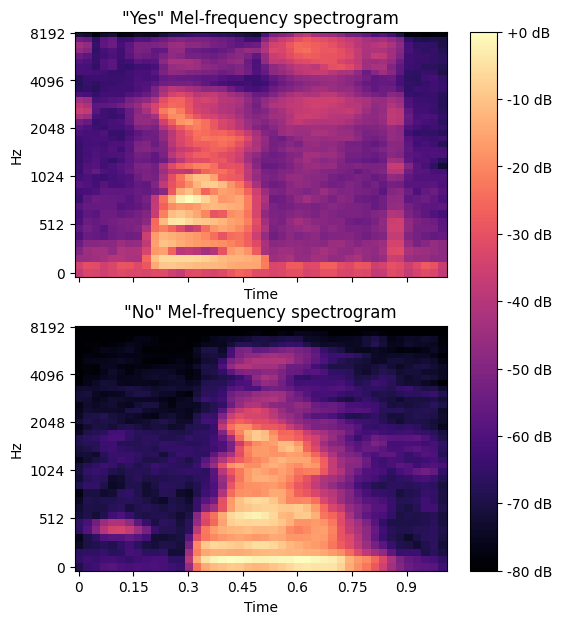

In [56]:
# plot example mel spectrograms
fig, ax = plt.subplots(figsize=(6,7), nrows=2, ncols=1, sharex=True)
y, sr = librosa.load('yes/00f0204f_nohash_0.wav')
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[0])
ax[0].set(title='"Yes" Mel-frequency spectrogram')
y, sr = librosa.load('no/0132a06d_nohash_3.wav')
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1])
ax[1].set(title='"No" Mel-frequency spectrogram')
fig.colorbar(img, ax=ax, format='%+2.0f dB')

# Super class classifier